In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys
print("at directory:", os.getcwd())
print("changing to root directory")
os.chdir("../..")
print("at directory:", os.getcwd())

at directory: /Users/wilka/git/research/jaxneurorl/projects/humansf
changing to root directory
at directory: /Users/wilka/git/research/jaxneurorl


In [4]:
import jax
import jax.numpy as jnp
import json
import functools

from xminigrid.rendering.rgb_render import render
import numpy as np
from IPython.display import Image

from library import parallel

from singleagent import value_based_basics as vbb

from projects.humansf import visualizer
from projects.humansf import keyroom
from projects.humansf import minigrid_common

In [5]:
# Open the file and load the JSON data
with open("projects/humansf/maze_pairs.json", "r") as file:
    maze_config = json.load(file)[0]

In [81]:
from pprint import pprint


pprint(maze_config)

size=16
env = keyroom.KeyRoom(
    train_episode_ends_on_pair_pickup=False,
)
env_params = env.default_params(
    maze_config=keyroom.shorten_maze_config(maze_config, 4),
    height=size,
    width=size,
)
env_params

{'keys': [['key', 'grey'],
          ['key', 'red'],
          ['key', 'purple'],
          ['key', 'yellow']],
 'pairs': [[['box', 'blue'], ['ball', 'blue']],
           [['box', 'purple'], ['box', 'green']],
           [['ball', 'green'], ['box', 'yellow']],
           [['key', 'blue'], ['key', 'green']]]}


KeyRoomEnvParams(height=16, width=16, view_size=7, render_mode='rgb_array', random_door_loc=False, train_multi_probs=0.5, training=True, time_limit=150, maze_config={'keys': Array([[9, 8],
       [9, 3],
       [9, 6],
       [9, 7]], dtype=uint8), 'pairs': Array([[[6, 5],
        [5, 5]],

       [[6, 6],
        [6, 4]],

       [[5, 4],
        [6, 7]],

       [[9, 5],
        [9, 4]]], dtype=uint8)}, task_objects=Array([[[ 9,  8,  1,  1],
        [12,  8,  1,  0],
        [ 6,  5,  1,  1],
        [ 5,  5,  1,  1]],

       [[ 9,  3,  1,  1],
        [12,  3,  1,  0],
        [ 6,  6,  1,  1],
        [ 6,  4,  1,  1]],

       [[ 9,  6,  1,  1],
        [12,  6,  1,  0],
        [ 5,  4,  1,  1],
        [ 6,  7,  1,  1]],

       [[ 9,  7,  1,  1],
        [12,  7,  1,  0],
        [ 9,  5,  1,  1],
        [ 9,  4,  1,  1]]], dtype=uint8), train_w=Array([[0.25, 0.5 , 1.  , 0.  ],
       [0.25, 0.5 , 1.  , 0.  ],
       [0.25, 0.5 , 1.  , 0.  ],
       [0.25, 0.5 , 1.  , 0.  ]],

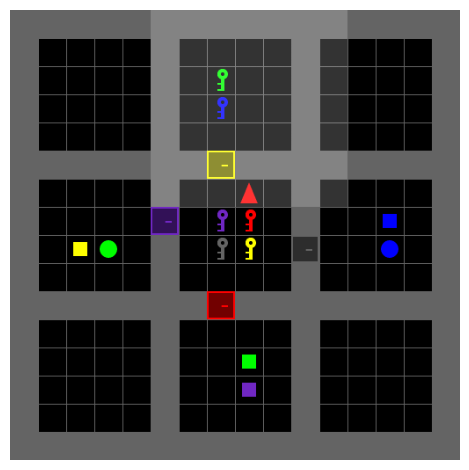

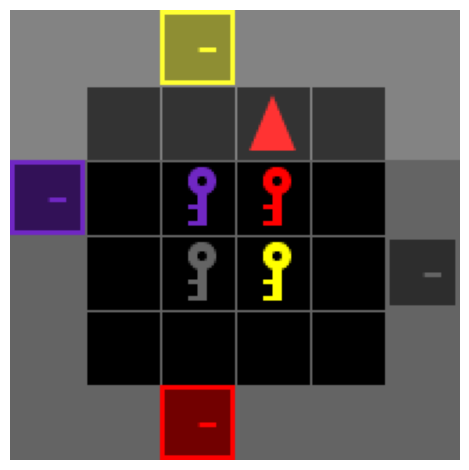

In [82]:
seed=3
rng = jax.random.PRNGKey(seed)
for seed in range(0, 1):
    rng, rng_ = jax.random.split(rng)
    timestep = env.reset(rng_, env_params)
    
    # get image of full state
    state_image = env.render(env_params, timestep)
    visualizer.display_image(state_image)
    
    # get image of what agent observes (theirs is symbolic)
    obs_image = keyroom.render_room(timestep.state)
    visualizer.display_image(obs_image)
    
    # jax.tree_map(lambda x:x.shape, timestep.observation)

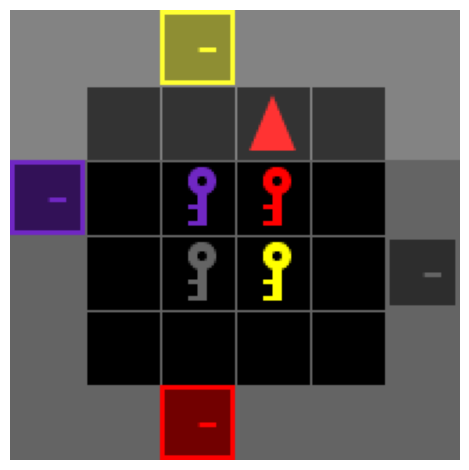

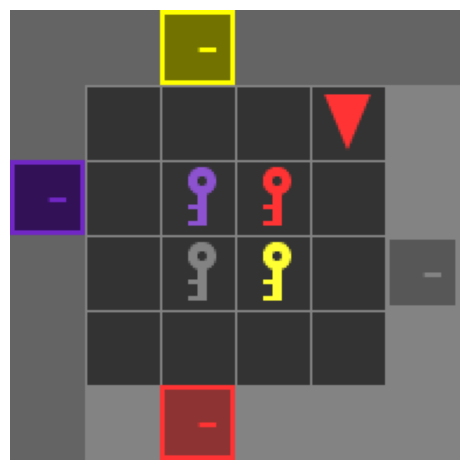

middle : r = 0.0 : gamma = 1.0


In [83]:
env = keyroom.KeyRoom(
    train_episode_ends_on_pair_pickup=False,
)
env_params = env.default_params(
    maze_config=keyroom.shorten_maze_config(maze_config, 4),
    height=size,
    width=size,
)
seed=3
rng = jax.random.PRNGKey(seed)
rng, rng_ = jax.random.split(rng)
timestep = env.reset(rng_, env_params)

all_actions = [
    'forward',
    'right',
    'left',
    'pickup',
    'put_down',
    'toggle',
]
action2idx = {a:i for i, a in enumerate(all_actions)}
actions = [
    'pickup', 
    'left', 'left',
    'forward', 'forward', 'toggle',
    'forward', 
    'forward', 
    'left', 'forward', 'right',
    'pickup'
]

seed=3
rng = jax.random.PRNGKey(seed)
rng, rng_ = jax.random.split(rng)
timestep = env.reset(rng_, env_params)
# timestep.observation.task_w
obs_image = keyroom.render_room(timestep.state)
visualizer.display_image(obs_image)

for action in actions:
    # print('-'*20)
    rng, rng_act, rng_step = jax.random.split(rng, 3)
    timestep = env.step(rng_step, timestep, action2idx[action], env_params)
obs_image = keyroom.render_room(timestep.state)
visualizer.display_image(obs_image)
print(['first', 'middle', 'last'][timestep.step_type],": r =", timestep.reward, ": gamma =", timestep.discount)


In [56]:
env.test_episodes_ends_on_key_pickup

True

In [57]:
env_params.training

True

In [9]:
colors = [
    "EMPTY",
    "END_OF_MAP",
    "UNSEEN",
    "RED",
    "GREEN",
    "BLUE",
    "PURPLE",
    "YELLOW",
    "GREY",
    "BLACK",
    "ORANGE",
    "WHITE",
    "BROWN",
    "PINK",
 ]
categories = [
    "EMPTY",
    "END_OF_MAP",
    "UNSEEN",
    "FLOOR",
    "WALL",
    "BALL",
    "SQUARE",
    "PYRAMID",
    "GOAL",
    "KEY",
    "DOOR_LOCKED",
    "DOOR_CLOSED",
    "DOOR_OPEN",
    "HEX",
    "STAR",
]

In [10]:
timestep.observation.task_w

Array([0., 0., 0., 1.], dtype=float32)

In [12]:
# timestep.state.agent.position, timestep.state.local_agent_position

def info(y, x):
    print('room')
    symbols = timestep.state.room_grid[y,x]
    print(f'symbolic at {y, x}', symbols)
    print(f'\t', colors[symbols[1]], categories[symbols[0]])
    print(timestep.observation.image[y,x])
    print(timestep.observation.image[y,x, symbols[0]], timestep.observation.image[y,x, len(categories)+symbols[1]])

# print("ball")
# info(2, 3)
info(3, 2)


room
symbolic at (3, 2) [5 5]
	 BLUE BALL
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0.]
1.0 1.0


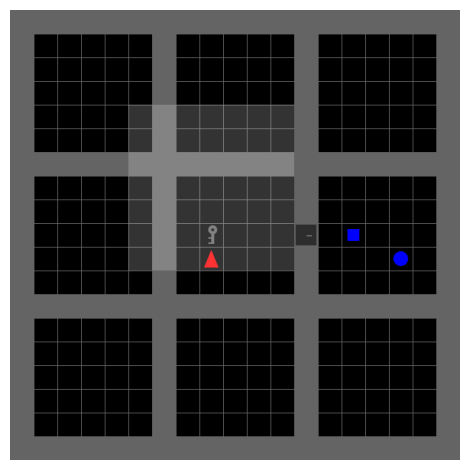

0.1
[1. 0. 0. 0.] [1. 0. 0. 0.] [0.1 0.5 1.  0. ]
[[2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2.]]


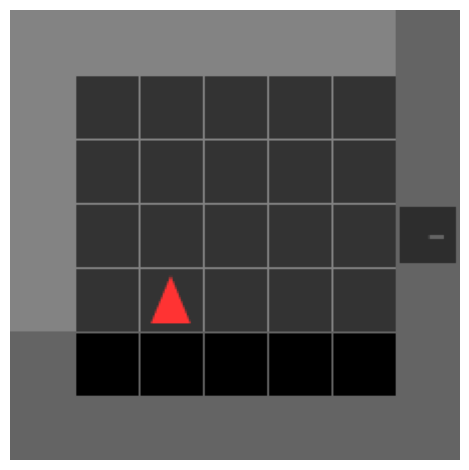

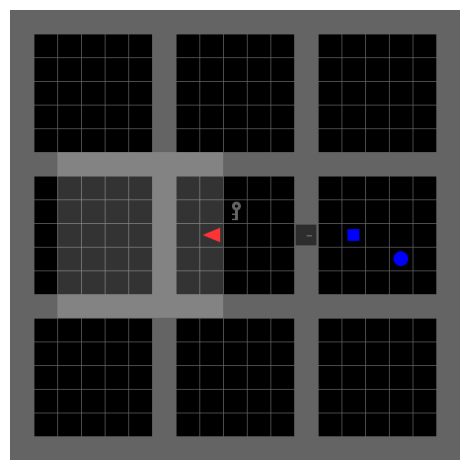

150 0.1


In [16]:
# rng = jax.random.PRNGKey(1)  # multiroom
rng = jax.random.PRNGKey(3)  # single room
rng, rng_ = jax.random.split(rng)
# rng, rng_ = jax.random.split(rng)
env_params = env_params.replace(training=True)
timestep = env.reset(rng_, env_params)
state_image = env.render(env_params, timestep)
visualizer.display_image(state_image)
t_limit = 150

# state_seq = [env.render(env_params, timestep)]
obs_seq = [keyroom.render_room(timestep.state)]
reward_seq = [timestep.reward]
timesteps = []

t_counter = 0
while True:
    rng, rng_act, rng_step = jax.random.split(rng, 3)
    action = jax.random.randint(rng_act, (), 0, env.num_actions(env_params))

    timestep = env.step(rng_step, timestep, action, env_params)
    # state_seq.append(env.render(env_params, timestep))
    obs_seq.append(keyroom.render_room(timestep.state))
    reward_seq.append(timestep.reward)
    # print('r=', timestep.reward, 'gamma=', timestep.discount)
    if timestep.reward > 0:
        obs = timestep.observation
        obs = jax.tree_map(lambda x: x.astype(jnp.float32), obs)

        print("="*10)
        print(timestep.reward)
        print(obs.state_features, obs.has_occurred, obs.task_w)
        print(obs.image.sum(-1))
        obs_image = keyroom.render_room(timestep.state)
        visualizer.display_image(obs_image)

    # obs_image = keyroom.render_room(timestep)
    # visualizer.display_image(obs_image)

    t_counter += 1
    if timestep.last() or t_counter >= t_limit:
        break

state_image = env.render(env_params, timestep)
visualizer.display_image(state_image)
cum_rewards = jnp.cumsum(jnp.array(reward_seq))
print(t_counter, sum(reward_seq))

MovieWriter ffmpeg unavailable; using Pillow instead.


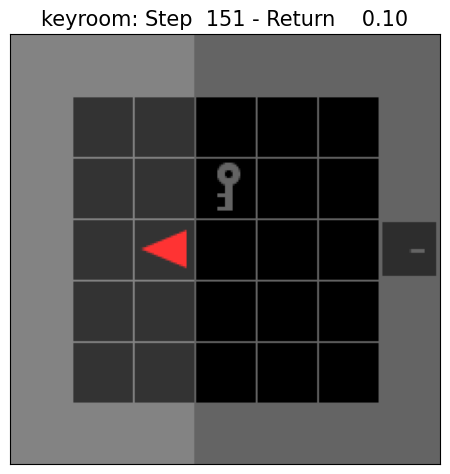

In [17]:
vis = visualizer.Visualizer(env, env_params, obs_seq, cum_rewards)
vis.animate(f"analysis_media/anim1.gif")
Image(url=f"analysis_media/anim1.gif")  